# Leer Nombres

In [1]:
import re

#Leer los nombres de la data (RGB, profundida, tipo)
def leerNombresTrain(path, cantMaxima):
    f = open(path, 'r+')
    
    pathNombresRGB = []
    pathNombresDepth = []
    clases = []
    cant = 0
    for line in f.readlines():
        
        line = line.split(" ")
        
        label = int( re.sub("\D", "", line[2]) ) -1
        if label<100:
            pathNombresRGB.append("SilentsData/NoSilent_"+line[0])
            pathNombresDepth.append("SilentsData/NoSilent_"+line[1])
            clases.append( label )

            cant = cant + 1
            if cant>=cantMaxima:
                break
        
    f.close()
    
    return pathNombresRGB, pathNombresDepth, clases

In [2]:
cantData = 200
pathNombresRGB, pathNombresDepth, clases = leerNombresTrain('../valid_list.txt', cantData)
print(len(pathNombresRGB))
print(len(pathNombresDepth))
print(len(clases))
#print(pathNombresRGB)
#print(pathNombresDepth)
#print(clases)

200
200
200


# Leer Video

In [3]:
import cv2
import numpy as np
import glob

#Se lee los videos rgb
def leer_una_sena_video(nombreVid):
    
    cap = cv2.VideoCapture('../'+nombreVid)
    vid = []
    while True:
        ret, img = cap.read()
        if not ret:
            break
        #vid.append(  cv2.resize(img, (160, 120) )   )    
        vid.append(  cv2.resize(img, (112,112))   )    
        #vid.append(img)    
    return vid

# Dar formato a la data para entrenar

In [4]:
def recortarVideo(vid, tam):
    razon = 1.0*len(vid)/tam
    vidR = []
    if (len(vid)<=0):
        return vidR
    for i in range(tam):
        vidR.append( vid[(int)(i*razon)] )
    del vid
    return vidR

In [5]:
def formatearVideo(vid):
    vid = np.array(vid)
    return vid

In [6]:
def juntarRGBandDepth(rgb, depth):
    return np.array( np.concatenate((rgb, depth)) )

In [7]:
def espejoVideo(vid):
    vidNew = []
    for img in vid:
        vidNew.append( cv2.flip( img, 1 ) )
    del vid
    return vidNew

In [8]:
def combinar(vid):
    vidRes = []
    vidRes.append(vid[0])
    vidRes.append(vid[3])
    vidRes.append(vid[1])
    vidRes.append(vid[4])
    vidRes.append(vid[2])
    vidRes.append(vid[5])
    return np.array(vidRes)

In [9]:
from skimage import exposure

def normalization_min_max(vid):
    vidNew = []
    
    for img in vid:
        img_norm = (img - np.min(img))/ (np.max(img) - np.min(img))
        #img_norm = exposure.equalize_adapthist(img, clip_limit=0.03)
        img_norm = exposure.equalize_hist(img_norm)

        
        vidNew.append( img_norm )
    del vid
    return vidNew

In [10]:
import numpy as np
import cv2

def substraerFondo(vidEntrada):
    vid = vidEntrada.copy()
    
    vidNew = []
    first_frame = vid[0]
    first_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    first_gray = cv2.GaussianBlur(first_gray, (5, 5), 0)
    for frame in vid:

        frameAux = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frameAux = cv2.GaussianBlur(frameAux, (5, 5), 0)
        frameAux = cv2.absdiff(first_gray, frameAux)

        _, frameAux = cv2.threshold(frameAux, 20, 255, cv2.THRESH_BINARY)
        
        frame[ frameAux==0 ] = 0
        vidNew.append(frame)
    
    del vid
    return np.array(vidNew)

In [11]:
numVid = 4
vidRGB = leer_una_sena_video(pathNombresRGB[numVid])
vidRGB = recortarVideo(vidRGB, 16)   
vidRGB = np.array(vidRGB)
print(vidRGB.shape)

(16, 112, 112, 3)


In [12]:
vidDepth = leer_una_sena_video(pathNombresDepth[numVid])
vidDepth = recortarVideo(vidDepth, 16)   
vidDepth = np.array(vidDepth)
print(vidDepth.shape)

(16, 112, 112, 3)


In [13]:
vidF = substraerFondo(vidRGB)
vidF.shape
print(vidF.shape)

(16, 112, 112, 3)


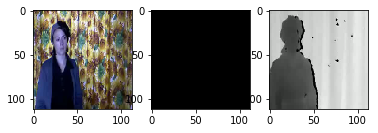

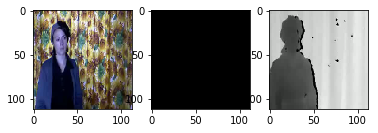

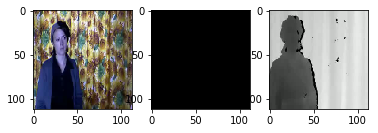

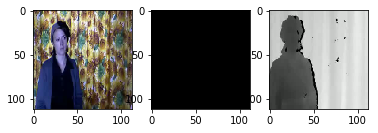

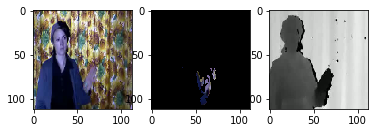

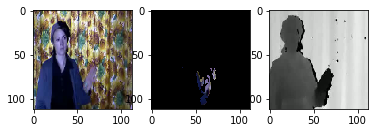

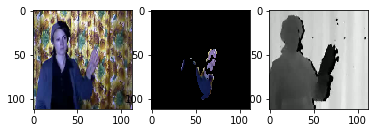

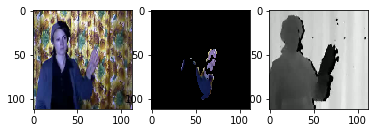

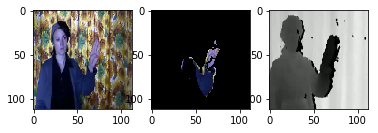

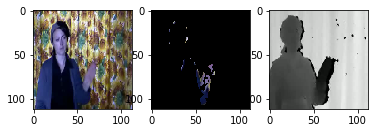

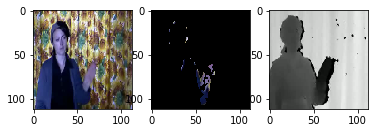

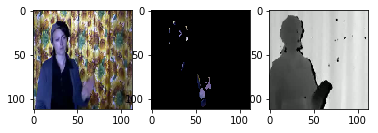

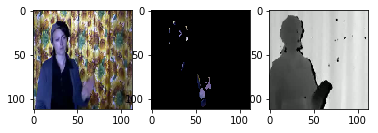

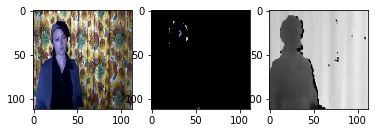

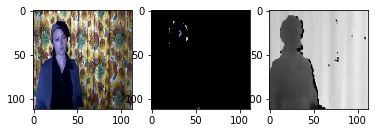

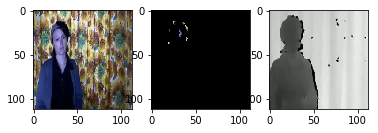

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()


for i in range(16):
    plt.subplot(1, 3, 1)
    b,g,r = cv2.split(vidRGB[i])       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(rgb_img)
    
    plt.subplot(1, 3, 2)
    b,g,r = cv2.split(vidF[i])       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(rgb_img)
    
    plt.subplot(1, 3, 3)
    plt.imshow(vidDepth[i])
    
    plt.show()
    

In [15]:
cantFrames = 16
bach_size = 8

In [16]:
cantData = 150
pathNombresRGB, pathNombresDepth, clases = leerNombresTrain('../train_list.txt', cantData)
len(pathNombresRGB)

150

In [17]:
from keras import utils
dataY_Entrada = utils.to_categorical(clases)
dataY_Entrada.shape

Using TensorFlow backend.


(150, 99)

In [18]:
def my_generator(pathNombresRGB, pathNombresDepth, cantFrames, cantData, dataY_Entrada, bach_size):
    i = 0
    boolEspejo = False
    while True:
        
        
        
        dataX = []
        dataXX = []
        dataY = []
        
        for _ in range(bach_size):
            
            if(i >= cantData*2):
            #if(i >= cantData):
                i=0
            
            if (boolEspejo):
                vidRGB = leer_una_sena_video(pathNombresRGB[(int)(i/2)])        
                vidRGB = recortarVideo(vidRGB, cantFrames)
                vidRGB = np.array(vidRGB)
                
                vidDepth = leer_una_sena_video(pathNombresDepth[(int)(i/2)])
                vidDepth = recortarVideo(vidDepth, cantFrames)
                vidDepth = np.array(vidDepth)
                
                
                vidRGB = substraerFondo(vidRGB)
                vidRGB = espejoVideo(vidRGB)
                vidRGB = formatearVideo(vidRGB)
                #vidRGB = vidRGB.transpose((3, 0, 1, 2))
                
                vidDepth = espejoVideo(vidDepth)
                vidDepth = (vidDepth - np.min(vidDepth))/ (np.max(vidDepth) - np.min(vidDepth))
                vidDepth = formatearVideo(vidDepth)
                #vidDepth = vidDepth.transpose((3, 0, 1, 2))

                #vid = juntarRGBandDepth(vidRGB, vidDepth)
                #vid = vid[0:4]
                #vid = vid.transpose((1, 2, 3, 0)) 


                boolEspejo = False

            else:
                vidRGB = leer_una_sena_video(pathNombresRGB[(int)(i/2)])        
                vidRGB = recortarVideo(vidRGB, cantFrames)
                vidRGB = np.array(vidRGB)
                
                vidDepth = leer_una_sena_video(pathNombresDepth[(int)(i/2)])
                vidDepth = recortarVideo(vidDepth, cantFrames)
                vidDepth = np.array(vidDepth)
                
                vidRGB = substraerFondo(vidRGB)
                vidRGB = formatearVideo(vidRGB)
                #vidRGB = vidRGB.transpose((3, 0, 1, 2))
                
                vidDepth = (vidDepth - np.min(vidDepth))/ (np.max(vidDepth) - np.min(vidDepth))
                vidDepth = formatearVideo(vidDepth)
                #vidDepth = vidDepth.transpose((3, 0, 1, 2))

                #vid = juntarRGBandDepth(vidRGB, vidDepth)
                #vid = vid[0:4]
                #vid = vid.transpose((1, 2, 3, 0))           

                boolEspejo = True
                
            
            '''
            vidRGB = leer_una_seña_video(pathNombresRGB[i])        
            vidRGB = recortarVideo(vidRGB, cantFrames)
            vidRGB = substraerFondo(vidRGB)
            vidRGB = formatearVideo(vidRGB)
            vidRGB = vidRGB.transpose((3, 0, 1, 2))
            
            
            vidDepth = leer_una_seña_video(pathNombresDepth[i])
            vidDepth = recortarVideo(vidDepth, cantFrames)
            vidDepth = (vidDepth - np.min(vidDepth))/ (np.max(vidDepth) - np.min(vidDepth))
            #vidDepth = vidDepth/256
            vidDepth = formatearVideo(vidDepth)
            vidDepth = vidDepth.transpose((3, 0, 1, 2))

            vid = juntarRGBandDepth(vidRGB, vidDepth)
            vid = vid[0:4]
            vid = vid.transpose((1, 2, 3, 0))
            '''
            
            #dataX.append(vid)
            dataX.append(vidRGB)
            dataXX.append(vidDepth)            
            
            #valY = dataY_Entrada[i]
            valY = dataY_Entrada[(int)(i/2)]
            dataY.append(valY)
            
            
            i += 1
        
        
        dataX = np.array(dataX)
        dataXX = np.array(dataXX)
        
        yield [dataX, dataXX], np.array(dataY)

# Entrenar

In [19]:
import numpy as np

bach_size_T = 8
bach_size_V = bach_size_T
cantFrames = 16

cantData_T = 35878
pathNombresRGB_T, pathNombresDepth_T, clases_T = leerNombresTrain('../train_list.txt', cantData_T)
print(len(pathNombresRGB_T))
dataY_Entrada_T = utils.to_categorical(clases_T)
print(dataY_Entrada_T.shape)

cantData_V = 5784
pathNombresRGB_V, pathNombresDepth_V, clases_V = leerNombresTrain('../valid_list.txt', cantData_V)
print(len(pathNombresRGB_V))
dataY_Entrada_V = utils.to_categorical(clases_V)
print(dataY_Entrada_V.shape)

16908
(16908, 100)
2375
(2375, 100)


In [20]:
cantData_T = len(pathNombresRGB_T)
cantData_V = len(pathNombresRGB_V)
cantData_T, cantData_V

(16908, 2375)

In [21]:
# Generators
training_generator = my_generator(pathNombresRGB_T, pathNombresDepth_T, cantFrames, cantData_T, dataY_Entrada_T, bach_size_T)
validation_generator = my_generator(pathNombresRGB_V, pathNombresDepth_V, cantFrames, cantData_V, dataY_Entrada_V, bach_size_V)

In [22]:
#dataR_X, dataR_Y = next(training_generator)
dataR_X, dataR_Y = next(training_generator)

In [23]:
dataR_X[0].shape

(8, 16, 112, 112, 3)

In [24]:
dataR_X[1].shape

(8, 16, 112, 112, 3)

## Modelo

In [25]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import MaxPooling3D, ZeroPadding3D, Conv3D
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.models import Model
from keras.layers import Input, Activation, Embedding, merge, LSTM, Dropout, Dense, RepeatVector, BatchNormalization, \
    TimeDistributed, Flatten, Reshape, concatenate

In [26]:
def get_model(summary=False):
    """ Return the Keras model of the network
    """
    
    inputs_RGB = Input(shape=(16, 112, 112, 3))
    
    # 1st layer group
    x = Conv3D(64, (3, 3, 3), activation='relu', padding='same', name='conv1', strides=(1, 1, 1))(inputs_RGB)
    x = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid', name='pool1')(x)
    
    # 2nd layer group
    x = Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv2', strides=(1, 1, 1))(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool2')(x)
    
    # 3rd layer group
    x = Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3a', strides=(1, 1, 1))(x)
    x = Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3b', strides=(1, 1, 1))(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool3')(x)
    
    # 4th layer group
    x = Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4a', strides=(1, 1, 1))(x)
    x = Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4b', strides=(1, 1, 1))(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool4')(x)
    
    # 5th layer group
    x = Conv3D(512, 3, 3, 3, activation='relu', padding='same', name='conv5a', strides=(1, 1, 1))(x)
    x = Conv3D(512, 3, 3, 3, activation='relu', padding='same', name='conv5b', strides=(1, 1, 1))(x)
    x = ZeroPadding3D(padding=(0, 1, 1))(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool5')(x)
    x = Flatten()(x)
    
    
    inputs_Depth = Input(shape=(16, 112, 112, 3))
    
    # 1st layer group
    y = Conv3D(64, (3, 3, 3), activation='relu', padding='same', name='Dconv1', strides=(1, 1, 1))(inputs_Depth)
    y = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid', name='Dpool1')(y)
    
    # 2nd layer group
    y = Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='Dconv2', strides=(1, 1, 1))(y)
    y = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='Dpool2')(y)
    
    # 3rd layer group
    y = Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='Dconv3a', strides=(1, 1, 1))(y)
    y = Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='Dconv3b', strides=(1, 1, 1))(y)
    y = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='Dpool3')(y)
    
    # 4th layer group
    y = Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='Dconv4a', strides=(1, 1, 1))(y)
    y = Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='Dconv4b', strides=(1, 1, 1))(y)
    y = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='Dpool4')(y)
    
    # 5th layer group
    y = Conv3D(512, 3, 3, 3, activation='relu', padding='same', name='Dconv5a', strides=(1, 1, 1))(y)
    y = Conv3D(512, 3, 3, 3, activation='relu', padding='same', name='Dconv5b', strides=(1, 1, 1))(y)
    y = ZeroPadding3D(padding=(0, 1, 1))(y)
    y = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='Dpool5')(y)
    y = Flatten()(y)
        
    
   
    merged = concatenate([x, y])
    
    
    # FC layers group
    x = Dense(4096, activation='relu', name='fc6')(merged)
    x = Dropout(.5)(x)
    x = Dense(4096, activation='relu', name='fc7')(x)
    x = Dropout(.5)(x)
    predictions = Dense(100, activation='softmax', name='fc8')(x)
    
    
    model = Model(inputs=[inputs_RGB, inputs_Depth], outputs=predictions)
    
    if summary:
        print(model.summary())
    return model


In [27]:
model = get_model(summary=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 112, 112, 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 16, 112, 112, 0                                            
__________________________________________________________________________________________________
conv1 (Conv3D)                  (None, 16, 112, 112, 5248        input_1[0][0]                    
__________________________________________________________________________________________________
Dconv1 (Conv3D)                 (None, 16, 112, 112, 5248        input_2[0][0]                    
__________________________________________________________________________________________________
pool1 (Max

/home/joel/.virtualenvs/gestos2/lib/python2.7/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(512, (3, 3, 3), padding="same", strides=(1, 1, 1), activation="relu", name="conv5a")`
/home/joel/.virtualenvs/gestos2/lib/python2.7/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(512, (3, 3, 3), padding="same", strides=(1, 1, 1), activation="relu", name="conv5b")`
/home/joel/.virtualenvs/gestos2/lib/python2.7/site-packages/ipykernel_launcher.py:54: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(512, (3, 3, 3), padding="same", strides=(1, 1, 1), activation="relu", name="Dconv5a")`
/home/joel/.virtualenvs/gestos2/lib/python2.7/site-packages/ipykernel_launcher.py:55: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(512, (3, 3, 3), padding="same", strides=(1, 1, 1), activation="relu", name="Dconv5b")`


In [28]:
#import keras
#from keras.models import model_from_json

#model = model_from_json(open('t_model_RGB_5.json', 'r').read())
#model.load_weights('t_weights_RGB_5.h5')

In [29]:
import keras
from keras.optimizers import Adam, SGD

sgd = SGD(lr=0.001, decay=5e-5, momentum=0.9)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=sgd, metrics=['acc'])

In [30]:
from keras.callbacks import TensorBoard

cantDataDoble_T = cantData_T*2
cantDataDoble_V = cantData_V*2

#cantDataDoble_T = cantData_T
#cantDataDoble_V = cantData_V
print(bach_size_T)
print(bach_size_V)


result_train = model.fit_generator(
    generator=training_generator,
    epochs=10,
    steps_per_epoch=cantDataDoble_T // bach_size_T,
    validation_data=validation_generator,
    validation_steps=cantDataDoble_V // bach_size_V)
'''

result_train = model.fit_generator(
    generator=training_generator,
    epochs=20,
    steps_per_epoch=cantDataDoble_T // bach_size_T)
'''

8
8
Epoch 1/10
   2/4227 [..............................] - ETA: 5:51:09 - loss: 5.6537 - acc: 0.0000e+00

KeyboardInterrupt: 

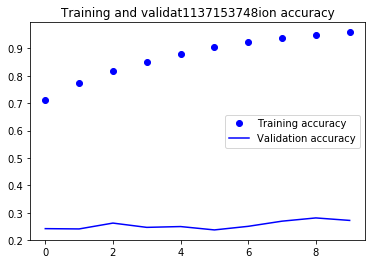

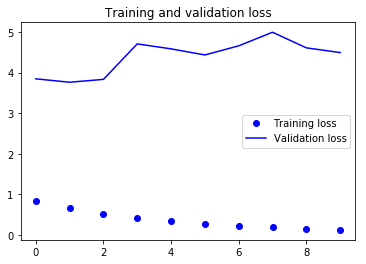

In [27]:
import matplotlib.pyplot as plt
accuracy = result_train.history['acc']
val_accuracy = result_train.history['val_acc']
loss = result_train.history['loss']
val_loss = result_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validat1137153748ion accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.show()

In [28]:
import h5py

model.save_weights('t_weights_RGBD_4.h5', overwrite=True)
json_string = model.to_json()
with open('t_model_RGBD_4.json', 'w') as f:
    f.write(json_string)

# Testing

Train

In [29]:
scores = model.evaluate_generator(generator=training_generator, steps=cantDataDoble_T // bach_size_T, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

2113/2113 [==============================] - 1341s 635ms/step
('Test loss:', 0.06388244950414099)
('Test accuracy:', 0.9795610506389021)


Valid

In [30]:
scores = model.evaluate_generator(generator=validation_generator, steps=cantDataDoble_V // bach_size_V, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

296/296 [==============================] - 189s 639ms/step
('Test loss:', 4.491446990016344)
('Test accuracy:', 0.27259290540540543)


Test

In [31]:
bach_size_Test = bach_size_T
cantFrames = 16

cantData_Test = 6271
pathNombresRGB_Test, pathNombresDepth_Test, clases_Test = leerNombresTrain('../test_list.txt', cantData_Test)
print(len(pathNombresRGB_Test))
dataY_Entrada_Test = utils.to_categorical(clases_Test)
print(dataY_Entrada_Test.shape)

# Generators
test_generator = my_generator(pathNombresRGB_Test, pathNombresDepth_Test, cantFrames, cantData_Test, dataY_Entrada_Test, bach_size_Test)
cantData_Test = len(pathNombresRGB_Test)

2533
(2533, 100)


In [32]:
scores = model.evaluate_generator(generator=test_generator, steps=cantData_Test // bach_size_Test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

158/158 [==============================] - 107s 678ms/step
('Test loss:', 4.574940009962154)
('Test accuracy:', 0.2998417721518987)
